In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
injury = pd.read_csv('severeinjury.csv')

C:\Users\bwils\anaconda3\envs\osha\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


We are going to look at OSHA recorded severe injuries between January 2015 and Spetmeber 2020. Interested to see if there is a pattern in what injuries lead to hospitalization and or amputation.

In [3]:
injury.head()

,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,...,Nature,NatureTitle,Part of Body,Part of Body Title,Event,EventTitle,Source,SourceTitle,Secondary Source,Secondary Source Title
0,2015010015,931176,1/1/2015,FCI Otisville Federal Correctional Institution,Two Mile Drive,NaN,OTISVILLE,NEW YORK,10963.0,41.46,...,111,Fractures,513,Lower leg(s),1214,Injured by physical contact with person while ...,5721,Co-worker,5772.0,Inmate or detainee in custody
1,2015010016,930267,1/1/2015,Kalahari Manufacturing LLC,171 Progress Drive,NaN,LAKE DELTON,WISCONSIN,53940.0,43.59,...,1522,Second degree heat (thermal) burns,519,"Leg(s), n.e.c.",317,"Ignition of vapors, gases, or liquids",7261,"Welding, cutting, and blow torches",NaN,NaN
2,2015010018,929823,1/1/2015,Schneider National Bulk Carrier,420 CORAOPOLIS ROAD,NaN,CORAOPOLIS,PENNSYLVANIA,15108.0,40.49,...,10,"Traumatic injuries and disorders, unspecified",9999,Nonclassifiable,4331,Other fall to lower level less than 6 feet,8421,"Semi, tractor-trailer, tanker truck",741.0,Ladders-fixed
3,2015010019,929711,1/1/2015,PEPSI BOTTLING GROUP INC.,4541 HOUSTON AVE.,NaN,MACON,GEORGIA,31206.0,32.77,...,1972,"Soreness, pain, hurt-nonspecified injury",510,"Leg(s), unspecified",640,Caught in or compressed by equipment or object...,8623,Pallet jack-powered,8420.0,"Truck-motorized freight hauling and utility, u..."
4,2015010020,929642,1/1/2015,North American Pipe Corporation,210 South Arch Street,NaN,JANESVILLE,WISCONSIN,53545.0,42.67,...,111,Fractures,4429,"Finger(s), fingernail(s), n.e.c.",6411,Caught in running equipment or machinery durin...,350,"Metal, woodworking, and special material machi...",NaN,NaN


There are a number of columns that we can elminate to make the data more manageable. Since most labor laws are made on the state and federal level we will drop location data except for state. Further inspection could be done on the dropped columns, but we are going to focus our search for now. The source data noted the the Lat and Long columns may be unreliable so we will be dropping them.

We can also drop the UPA ID as it is a duplicate ID, and the Final Narrative. We could run NLP on the FInal Narrative, but that is beyond the scope of this review. 

We will also drop titles columns after constructing dictionaries for labeling them later.

In [4]:
injury.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59469 entries, 0 to 59468
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      59469 non-null  int64  
 1   UPA                     59469 non-null  int64  
 2   EventDate               59469 non-null  object 
 3   Employer                59469 non-null  object 
 4   Address1                59457 non-null  object 
 5   Address2                5488 non-null   object 
 6   City                    59457 non-null  object 
 7   State                   59469 non-null  object 
 8   Zip                     59455 non-null  float64
 9   Latitude                59441 non-null  float64
 10  Longitude               59441 non-null  float64
 11  Primary NAICS           59467 non-null  object 
 12  Hospitalized            59469 non-null  float64
 13  Amputation              59467 non-null  float64
 14  Inspection              20129 non-null

Before we drop them we will first fill in our missing fields. 
- Because we don't intend to use them in our analysis we will ignore the following: Address1, Address2, City, Zip, Latitude, Longitude. 
- Primary NAICS will be filled with 0 as will hospitalization and amputation. 
- Inspections will be converted to a binary column as the report numbers don't provide us with further information.
- Secondary Souce will be filled with 0 and Secondary Source Title will be filled with None

In [5]:
fill = {'Primary NAICS':0, 'Hospitalized':0, 'Amputation':0, 'Inspection':0, 
        'Secondary Source':0, 'Secondary Source Title':'None'}
injury.fillna(value=fill, inplace=True)

In [6]:
injury.loc[injury['Inspection']!=0, 'Inspection'] = 1
injury.head()

,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,...,Nature,NatureTitle,Part of Body,Part of Body Title,Event,EventTitle,Source,SourceTitle,Secondary Source,Secondary Source Title
0,2015010015,931176,1/1/2015,FCI Otisville Federal Correctional Institution,Two Mile Drive,NaN,OTISVILLE,NEW YORK,10963.0,41.46,...,111,Fractures,513,Lower leg(s),1214,Injured by physical contact with person while ...,5721,Co-worker,5772.0,Inmate or detainee in custody
1,2015010016,930267,1/1/2015,Kalahari Manufacturing LLC,171 Progress Drive,NaN,LAKE DELTON,WISCONSIN,53940.0,43.59,...,1522,Second degree heat (thermal) burns,519,"Leg(s), n.e.c.",317,"Ignition of vapors, gases, or liquids",7261,"Welding, cutting, and blow torches",0.0,None
2,2015010018,929823,1/1/2015,Schneider National Bulk Carrier,420 CORAOPOLIS ROAD,NaN,CORAOPOLIS,PENNSYLVANIA,15108.0,40.49,...,10,"Traumatic injuries and disorders, unspecified",9999,Nonclassifiable,4331,Other fall to lower level less than 6 feet,8421,"Semi, tractor-trailer, tanker truck",741.0,Ladders-fixed
3,2015010019,929711,1/1/2015,PEPSI BOTTLING GROUP INC.,4541 HOUSTON AVE.,NaN,MACON,GEORGIA,31206.0,32.77,...,1972,"Soreness, pain, hurt-nonspecified injury",510,"Leg(s), unspecified",640,Caught in or compressed by equipment or object...,8623,Pallet jack-powered,8420.0,"Truck-motorized freight hauling and utility, u..."
4,2015010020,929642,1/1/2015,North American Pipe Corporation,210 South Arch Street,NaN,JANESVILLE,WISCONSIN,53545.0,42.67,...,111,Fractures,4429,"Finger(s), fingernail(s), n.e.c.",6411,Caught in running equipment or machinery durin...,350,"Metal, woodworking, and special material machi...",0.0,None


In [7]:
injury1 = injury.drop(columns=['UPA', 'Address1', 'Address2', 'City', 'Zip', 'Latitude', 'Longitude'])

In [8]:
injury1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59469 entries, 0 to 59468
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      59469 non-null  int64  
 1   EventDate               59469 non-null  object 
 2   Employer                59469 non-null  object 
 3   State                   59469 non-null  object 
 4   Primary NAICS           59469 non-null  object 
 5   Hospitalized            59469 non-null  float64
 6   Amputation              59469 non-null  float64
 7   Inspection              59469 non-null  float64
 8   Final Narrative         59469 non-null  object 
 9   Nature                  59469 non-null  int64  
 10  NatureTitle             59469 non-null  object 
 11  Part of Body            59469 non-null  int64  
 12  Part of Body Title      59469 non-null  object 
 13  Event                   59469 non-null  int64  
 14  EventTitle              59469 non-null

In [9]:
pob = injury1[['Part of Body', 'Part of Body Title']].groupby('Part of Body').first()
pob_labels = dict(zip(pob.index, pob['Part of Body Title']))
pob_labels

{6: 'BODY SYSTEMS',
 10: 'Head, unspecified',
 12: 'Ear(s)',
 18: 'Multiple head locations',
 20: 'Neck, except internal location of diseases or disorders',
 21: 'Internal neck location, unspecified',
 30: 'Trunk, unspecified',
 38: 'Multiple trunk locations',
 40: 'Upper extremities, unspecified',
 41: 'Shoulder(s), including clavicle(s), scapula(e)',
 43: 'Wrist(s)',
 49: 'Upper extremities, n.e.c.',
 50: 'Lower extremities, unspecified',
 52: 'Ankle(s)',
 59: 'Lower extremities, n.e.c.',
 80: 'Multiple body parts, unspecified',
 81: 'Head and neck',
 82: 'Head, neck, and trunk',
 83: 'Head and trunk',
 84: 'Neck and back',
 85: 'Shoulder(s) and back',
 86: 'Hip(s) and leg(s) ',
 87: 'Upper and lower limb(s)',
 110: 'Cranial region, unspecified',
 111: 'Brain',
 112: 'Scalp',
 113: 'Skull',
 118: 'Multiple cranial region locations',
 119: 'Cranial region, n.e.c.',
 130: 'Face, unspecified',
 131: 'Forehead',
 132: 'Eye(s)',
 134: 'Cheek(s)',
 135: 'Jaw, chin',
 138: 'Multiple face lo

In [10]:
nature = injury1[['Nature', 'NatureTitle']].groupby('Nature').first()
nature_labels = dict(zip(nature.index, nature['NatureTitle']))
nature_labels

{7: 'EXPOSURES TO DISEASE-NO ILLNESS INCURRED',
 8: 'MULTIPLE DISEASES, CONDITIONS, AND DISORDERS',
 10: 'Traumatic injuries and disorders, unspecified',
 21: 'Anemia and other diseases of the blood and blood forming organs',
 30: 'Infectious and parasitic diseases, unspecified',
 58: 'Multiple symptoms, signs, and ill-defined conditions',
 110: 'Traumatic injuries to bones, nerves, spinal cord, unspecified',
 111: 'Fractures',
 118: 'Multiple traumatic injuries to bones, nerves, spinal cord',
 119: 'Traumatic injuries to bones, nerves, spinal cord, n.e.c.',
 120: 'Traumatic injuries to muscles, tendons, ligaments, joints, etc., unspecified',
 124: 'Hernias due to traumatic incidents',
 125: 'Whiplash',
 128: 'Multiple traumatic injuries to muscles, tendons, ligaments, joints, etc.',
 129: 'Traumatic injuries to muscles, tendons, ligaments, joints, etc., n.e.c.',
 130: 'Open wounds, unspecified',
 132: 'Cuts, lacerations',
 133: 'Puncture wounds, except gunshot wounds',
 134: 'Gunshot 

In [11]:
event = injury1[['Event', 'EventTitle']].groupby('Event').first()
event_labels = dict(zip(event.index, event['EventTitle']))
event_labels

{20: 'Transportation incident, unspecified',
 30: 'Fire or explosion, unspecified ',
 40: 'Fall, slip, trip, unspecified ',
 45: 'Fall or jump curtailed by personal fall arrest system ',
 49: 'Fall, slip, trip, n.e.c.',
 50: 'Exposure to harmful substances or environments, unspecified',
 57: 'Exposure to traumatic or stressful event, n.e.c. ',
 59: 'Exposure to harmful substances or environments, n.e.c.',
 60: 'Contact with objects and equipment, unspecified',
 61: 'Needlestick without exposure to harmful substance',
 69: 'Contact with objects and equipment, n.e.c.',
 70: 'Overexertion and bodily reaction, unspecified',
 74: 'Bodily conditions, n.e.c.',
 78: 'Multiple types of overexertions and bodily reactions',
 79: 'Overexertion and bodily reaction and exertion, n.e.c.',
 129: 'Injury by person-unintentional or intent unknown, n.e.c.',
 130: 'Animal and insect related incidents, unspecified',
 139: 'Animal and insect related incidents, n.e.c.',
 210: 'Aircraft incident, unspecified'

In [12]:
source = injury1[['Source', 'SourceTitle']].groupby('Source').first()
source_labels = dict(zip(source.index, source['SourceTitle']))
source_labels

{10: 'Chemicals and chemical products, unspecified',
 19: 'Chemicals and chemical products, n.e.c.',
 20: 'Containers, furniture, and fixtures, unspecified',
 30: 'Machinery, unspecified',
 40: 'Parts and materials, unspecified',
 60: 'Structures and surfaces, unspecified',
 69: 'Structures and surfaces, n.e.c.',
 70: 'Tools, instruments, and equipment, unspecified',
 80: 'Vehicle, unspecified',
 99: 'Source, n.e.c.',
 120: 'Aromatics and hydrocarbon derivatives, except halogenated,  unspecified',
 128: 'Multiple aromatics and hydrocarbon derivatives, except halogenated',
 139: 'Halogens and halogen compounds, n.e.c.',
 140: 'Metallic particulates, trace elements, dusts, powders, fumes,  unspecified',
 147: 'Welding or soldering fumes, unspecified or n.e.c.',
 150: 'Pesticides and other agricultural chemicals, unspecified',
 151: 'Fertilizers, plant food, n.e.c.',
 152: 'Fumigants, n.e.c.',
 153: 'Fungicides',
 154: 'Herbicides',
 155: 'Insecticides',
 160: 'Coal, natural gas, petroleu

In [13]:
sec_source = injury1[['Secondary Source', 'Secondary Source Title']].groupby('Secondary Source').first()
sec_source_labels = dict(zip(sec_source.index, sec_source['Secondary Source Title']))
sec_source_labels

{0.0: 'None',
 10.0: 'Chemicals and chemical products, unspecified',
 30.0: 'Machinery, unspecified',
 40.0: 'Parts and materials, unspecified',
 60.0: 'Structures and surfaces, unspecified',
 69.0: 'Structures and surfaces, n.e.c.',
 70.0: 'Tools, instruments, and equipment, unspecified',
 80.0: 'Vehicle, unspecified',
 90.0: 'Other sources, unspecified',
 99.0: 'Source, n.e.c.',
 144.0: 'Lead and compounds',
 150.0: 'Pesticides and other agricultural chemicals, unspecified',
 160.0: 'Coal, natural gas, petroleum fuels and products, unspecified',
 162.0: 'Natural gas',
 163.0: 'Petroleum, crude oil',
 172.0: 'Cryogenic gases',
 178.0: 'Multiple chemicals or chemical mixtures, n.e.c.',
 180.0: 'Chemical products, unspecified',
 181.0: 'Adhesives, glues, n.e.c.',
 210.0: 'Containers, unspecified',
 216.0: 'Skids, pallets',
 220.0: 'Furniture and fixtures, unspecified',
 229.0: 'Furniture and fixtures, n.e.c.',
 310.0: 'Agricultural and garden machinery, unspecified',
 320.0: 'Constructi

In [14]:
injury2 = injury1.drop(columns=['Part of Body Title', 'NatureTitle', 'EventTitle', 
                               'SourceTitle', 'Secondary Source Title','Final Narrative'])
injury2

,ID,EventDate,Employer,State,Primary NAICS,Hospitalized,Amputation,Inspection,Nature,Part of Body,Event,Source,Secondary Source
0,2015010015,1/1/2015,FCI Otisville Federal Correctional Institution,NEW YORK,922140,1.0,0.0,1.0,111,513,1214,5721,5772.0
1,2015010016,1/1/2015,Kalahari Manufacturing LLC,WISCONSIN,339999,1.0,0.0,1.0,1522,519,317,7261,0.0
2,2015010018,1/1/2015,Schneider National Bulk Carrier,PENNSYLVANIA,484121,1.0,0.0,0.0,10,9999,4331,8421,741.0
3,2015010019,1/1/2015,PEPSI BOTTLING GROUP INC.,GEORGIA,424490,1.0,0.0,1.0,1972,510,640,8623,8420.0
4,2015010020,1/1/2015,North American Pipe Corporation,WISCONSIN,326122,1.0,0.0,1.0,111,4429,6411,350,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59464,2020099293,9/30/2020,United States Postal Service,OH,491110,1.0,0.0,0.0,194,330,4330,6610,660.0
59465,2020099295,9/30/2020,"Endo-Therapeutics, Inc.",FL,334510,0.0,1.0,0.0,1311,4422,6419,3511,0.0
59466,2020099296,9/30/2020,"Fred Usinger, Inc.",WI,311612,0.0,1.0,0.0,1311,4422,6311,3713,0.0
59467,2020099297,9/30/2020,Treesmiths Inc,PA,561730,1.0,0.0,1.0,111,899,4336,5871,660.0


In [15]:
injury2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59469 entries, 0 to 59468
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                59469 non-null  int64  
 1   EventDate         59469 non-null  object 
 2   Employer          59469 non-null  object 
 3   State             59469 non-null  object 
 4   Primary NAICS     59469 non-null  object 
 5   Hospitalized      59469 non-null  float64
 6   Amputation        59469 non-null  float64
 7   Inspection        59469 non-null  float64
 8   Nature            59469 non-null  int64  
 9   Part of Body      59469 non-null  int64  
 10  Event             59469 non-null  int64  
 11  Source            59469 non-null  int64  
 12  Secondary Source  59469 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usage: 5.9+ MB


We should correct some of our datatypes now that we have cleaned out the columns we won't be looking at. Changing numerical columns to numerical datatypes makes for simplier analysis.

In [16]:
injury2['EventDate'] = pd.to_datetime(injury2['EventDate'])
#injury2['Primary NAICS'] = injury2['Primary NAICS'].astype('int64')
injury2['Hospitalized'] = injury2['Hospitalized'].astype('int64')
injury2['Amputation'] = injury2['Amputation'].astype('int64')
injury2['Inspection'] = injury2['Inspection'].astype('int64')
injury2['Secondary Source'] = injury['Secondary Source'].astype('int64')
injury2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59469 entries, 0 to 59468
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                59469 non-null  int64         
 1   EventDate         59469 non-null  datetime64[ns]
 2   Employer          59469 non-null  object        
 3   State             59469 non-null  object        
 4   Primary NAICS     59469 non-null  object        
 5   Hospitalized      59469 non-null  int64         
 6   Amputation        59469 non-null  int64         
 7   Inspection        59469 non-null  int64         
 8   Nature            59469 non-null  int64         
 9   Part of Body      59469 non-null  int64         
 10  Event             59469 non-null  int64         
 11  Source            59469 non-null  int64         
 12  Secondary Source  59469 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(3)
memory usage: 5.9+ MB


Let's use our new datetime column to create a month and year column

In [17]:
injury2['year'] = injury2['EventDate'].dt.year
injury2['month'] = injury2['EventDate'].dt.month
injury2

,ID,EventDate,Employer,State,Primary NAICS,Hospitalized,Amputation,Inspection,Nature,Part of Body,Event,Source,Secondary Source,year,month
0,2015010015,2015-01-01,FCI Otisville Federal Correctional Institution,NEW YORK,922140,1,0,1,111,513,1214,5721,5772,2015,1
1,2015010016,2015-01-01,Kalahari Manufacturing LLC,WISCONSIN,339999,1,0,1,1522,519,317,7261,0,2015,1
2,2015010018,2015-01-01,Schneider National Bulk Carrier,PENNSYLVANIA,484121,1,0,0,10,9999,4331,8421,741,2015,1
3,2015010019,2015-01-01,PEPSI BOTTLING GROUP INC.,GEORGIA,424490,1,0,1,1972,510,640,8623,8420,2015,1
4,2015010020,2015-01-01,North American Pipe Corporation,WISCONSIN,326122,1,0,1,111,4429,6411,350,0,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59464,2020099293,2020-09-30,United States Postal Service,OH,491110,1,0,0,194,330,4330,6610,660,2020,9
59465,2020099295,2020-09-30,"Endo-Therapeutics, Inc.",FL,334510,0,1,0,1311,4422,6419,3511,0,2020,9
59466,2020099296,2020-09-30,"Fred Usinger, Inc.",WI,311612,0,1,0,1311,4422,6311,3713,0,2020,9
59467,2020099297,2020-09-30,Treesmiths Inc,PA,561730,1,0,1,111,899,4336,5871,660,2020,9


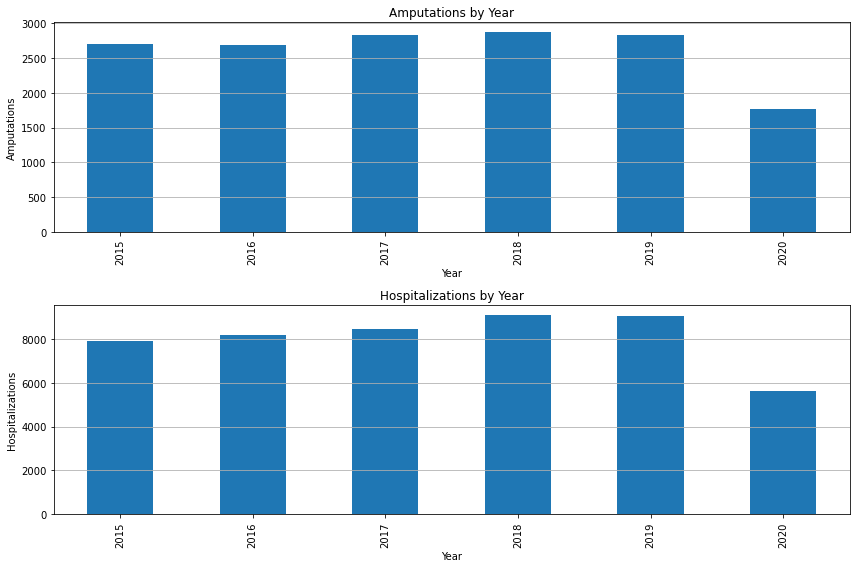

In [18]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
injury2.groupby('year')['Amputation'].sum().plot(ax=ax1, kind='bar')
ax1.set_title('Amputations by Year')
ax1.set_xlabel('Year')
ax1.grid(b=True, axis='y')
ax1.set_ylabel('Amputations')

injury2.groupby('year')['Hospitalized'].sum().plot(ax=ax2, kind='bar')
ax2.set_title('Hospitalizations by Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Hospitalizations')
ax2.grid(b=True, axis='y')
fig.tight_layout()
plt.show()

Remember that we are missing 3 months of data for 2020, but much of the drop off was likely from COVID reducing the amount of total work.

Both do show a trend upwards over the last few years, but it would be important to compare this to total hours worked to see if the number of incidents vs hours worked was increasing or decreasing.

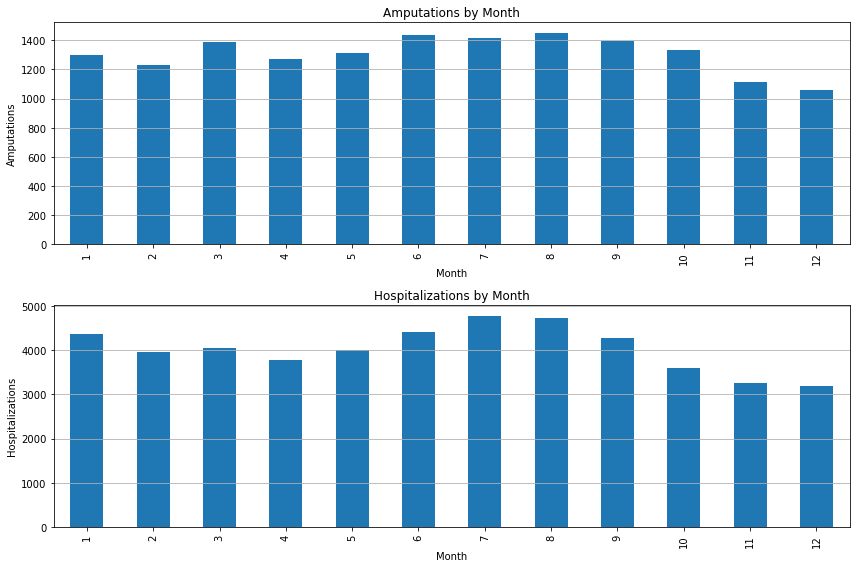

In [19]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
injury2.groupby('month')['Amputation'].sum().plot(ax=ax1, kind='bar')
ax1.set_title('Amputations by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Amputations')
ax1.grid(b=True, axis='y')

injury2.groupby('month')['Hospitalized'].sum().plot(ax=ax2, kind='bar')
ax2.set_title('Hospitalizations by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Hospitalizations')
ax2.grid(b=True, axis='y')
fig.tight_layout()
plt.show()

There appears to be a trend up during the later summer months when more construction work is happening as well as in January. The January uptick is likely due to a return from holidays when people are not quite focused back on work yet.

In [20]:
injury2['State'].unique()

array(['NEW YORK', 'WISCONSIN', 'PENNSYLVANIA', 'GEORGIA', 'FLORIDA',
       'COLORADO', 'OKLAHOMA', 'TEXAS', 'LOUISIANA', 'MISSISSIPPI',
       'NEW JERSEY', 'OHIO', 'ILLINOIS', 'NEBRASKA', 'NEW HAMPSHIRE',
       'KANSAS', 'MASSACHUSETTS', 'ARKANSAS', 'MICHIGAN', 'IDAHO',
       'MISSOURI', 'MAINE', 'CONNECTICUT', 'WEST VIRGINIA',
       'NORTH DAKOTA', 'MONTANA', 'NORTH CAROLINA', 'DELAWARE',
       'CALIFORNIA', 'AMERICAN SAMOA', 'DISTRICT OF COLUMBIA', 'ALABAMA',
       'TENNESSEE', 'OREGON', 'SOUTH DAKOTA', 'RHODE ISLAND', 'INDIANA',
       'VIRGINIA', 'NEW MEXICO', 'MARYLAND', 'UTAH', 'VERMONT', 'ARIZONA',
       'GUAM', 'IOWA', 'KENTUCKY', 'MINNESOTA', 'WASHINGTON',
       'SOUTH CAROLINA', 'HAWAII', 'PUERTO RICO', 'VIRGIN ISLANDS',
       'NEVADA', 'WYOMING', 'NORTHERN MARIANA ISLANDS', 'ALASKA', 'PA',
       'FL', 'OH', 'TX', 'MO', 'IL', 'AL', 'ME', 'NJ', 'NY', 'MA', 'DE',
       'WY', 'KS', 'NE', 'CO', 'GA', 'MS', 'WI', 'CA', 'CT', 'LA', 'AR',
       'MT', 'OR', 'WV', 'NC', 

Let's quickly clean this up so that we don't have duplicates

In [21]:
state_mapper = {'NY':'NEW YORK', 'WI':'WISCONSIN', 'PA':'PENNSYLVANIA', 'GA':'GEORGIA', 
                'FL':'FLORIDA', 'CO':'COLORADO', 'OK':'OKLAHOMA', 'TX':'TEXAS', 'LA':'LOUISIANA',
                'MI':'MISSISSIPPI','NJ':'NEW JERSEY', 'OH':'OHIO', 'IL':'ILLINOIS', 'NE':'NEBRASKA',
                'NH':'NEW HAMPSHIRE', 'KS':'KANSAS', 'MA':'MASSACHUSETTS', 'AR':'ARKANSAS', 
                'MI':'MICHIGAN', 'ID':'IDAHO', 'MI':'MISSOURI', 'ME':'MAINE', 'CT':'CONNECTICUT',
                'WV':'WEST VIRGINIA', 'ND':'NORTH DAKOTA', 'MT':'MONTANA', 'NC':'NORTH CAROLINA',
                'DE':'DELAWARE', 'CA':'CALIFORNIA', 'DC':'DISTRICT OF COLUMBIA', 'AL':'ALABAMA',
                'TN':'TENNESSEE', 'OR':'OREGON', 'SD':'SOUTH DAKOTA', 'RI':'RHODE ISLAND', 
                'IN':'INDIANA', 'VA':'VIRGINIA', 'NM':'NEW MEXICO', 'MD':'MARYLAND', 'UT':'UTAH', 
                'VT':'VERMONT', 'AZ':'ARIZONA', 'IA':'IOWA', 'KY':'KENTUCKY', 'MN':'MINNESOTA',
                'WA':'WASHINGTON', 'SC':'SOUTH CAROLINA', 'HI':'HAWAII', 'PR':'PUERTO RICO', 
                'VI':'VIRGIN ISLANDS','GU':'GUAM', 'NV':'NEVADA', 'WY':'WYOMING', 
                'AK':'ALASKA', 'NMI':'NORTHERN MARIANA ISLANDS', 'AS':'AMERICAN SAMOA'} 

injury2['State'].replace(state_mapper, inplace=True)
injury2['State'].unique()

In [23]:
injury2.groupby('State')['ID'].count().sort_values(ascending=False).head(15)

State
TX    9893
FL    6145
PA    4722
OH    4572
IL    3596
GA    3248
NY    3003
MI    2962
WI    2463
CO    1926
AL    1915
NJ    1504
LA    1441
MA    1355
AR    1287
Name: ID, dtype: int64

While it isn't surprsing to see may of the higher population states represented in the top 10, it is surprising to see CA not in the top 15 as the most populous state. Let's take a look at what the top Nature of injury is for each state.

In [24]:
nature_max = injury2.groupby('State')['Nature'].apply(lambda x: x.value_counts()
                                                      .sort_values(ascending=False).head(1)).unstack()
nature_max.head()

,111,132,1311,1720,1839
State,,,,,
AK,10.0,NaN,NaN,NaN,NaN
AL,NaN,NaN,596.0,NaN,NaN
AR,NaN,NaN,445.0,NaN,NaN
AS,NaN,NaN,4.0,NaN,NaN
AZ,22.0,NaN,NaN,NaN,NaN


Apparently 5 Natures of injury are consistenly make up all the max injuries for each state.

In [25]:
nature_max.columns = nature_max.columns.map(nature_labels)
nature_max.head()

,Fractures,"Cuts, lacerations",Amputations,"Effects of heat and light, unspecified","Fractures and other injuries, n.e.c."
State,,,,,
AK,10.0,NaN,NaN,NaN,NaN
AL,NaN,NaN,596.0,NaN,NaN
AR,NaN,NaN,445.0,NaN,NaN
AS,NaN,NaN,4.0,NaN,NaN
AZ,22.0,NaN,NaN,NaN,NaN


THis is important infomration that a safety officer could use to determine types of work to watch more carefully or review policy on. 